In [1]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

In [2]:
SEDM_ML_sample = Table.read("/home/xhall/Documents/NewZTF/ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [3]:
snidoutput = np.load("/home/xhall/Documents/NewZTF/SNIDoutput.npy",allow_pickle=True)

In [5]:
final_rcf_table = Table.from_pandas(pd.read_hdf("/home/xhall/Documents/NewZTF/final_rcf_table.h5"))

In [15]:
ZTable_best_only = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    row.append(float(j[1][0]["z"]))
    row.append(float(j[1][0]["zerr"]))
    ZTable_best_only.add_row(row)
ZTable_best_only_JoinedResults = astropy.table.join(astropy.table.join(ZTable_best_only, SEDM_ML_sample),final_rcf_table)

In [26]:
print(len(ZTable_best_only))
print(len(SEDM_ML_sample))

8374
8959


In [117]:
regr_best_only_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_best_only_JoinedResults_good = ZTable_best_only_JoinedResults[np.where(ZTable_best_only_JoinedResults["z_host"] > -.1)[0]]
regr_best_only_JoinedResults_good.fit(ZTable_best_only_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_best_only_JoinedResults_good["z_snid"].reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [118]:
ranges_best_good = np.linspace(0, .2, 100)
ypredict_best_only_good = regr_best_only_JoinedResults_good.predict(ranges_best_good.reshape(-1, 1))

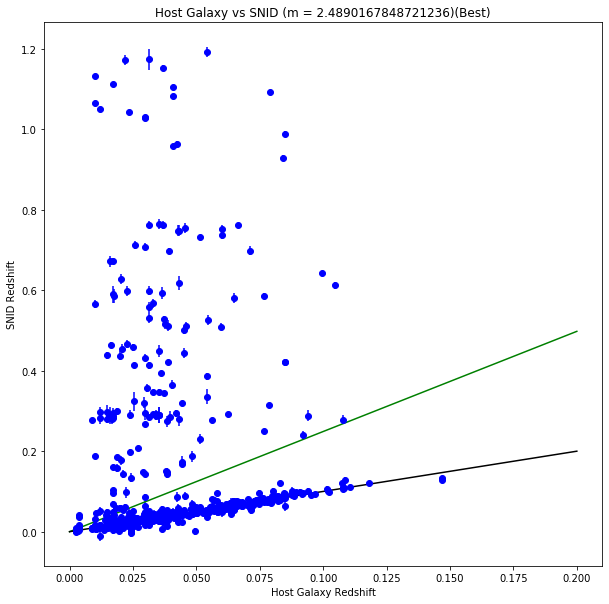

In [142]:
fig = plt.figure(figsize = (10,10))
#plt.xlim(0,.2)
#plt.ylim(0,.2)
plt.errorbar(ZTable_best_only_JoinedResults_good["z_host"], ZTable_best_only_JoinedResults_good["z_snid"], ZTable_best_only_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_only_JoinedResults_good.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_best_good, ypredict_best_only_good, color = "green")
plt.plot(ranges_best_good, ranges_best_good, color = "black")

In [152]:
print(stats.median_absolute_deviation(ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"])/ZTable_best_only_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]))
print(np.std((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_host"]))
print(np.std(((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"]) / ZTable_best_only_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_best_only_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.008284768800000003
0.21272906578068693
1.7400889102167196
0.21799525086003962
9.860286348507215
71.04164880998681
744 764


In [159]:
print(np.sum(np.abs((ZTable_best_only_JoinedResults_good["z_snid"] - ZTable_best_only_JoinedResults_good["z_host"])/ZTable_best_only_JoinedResults_good["z_host"]) > .5),len(ZTable_best_only_JoinedResults_good))

196 701


In [169]:
counter = 0
for i in (np.unique(ZTable_best_only_JoinedResults_good["ZTF_Name"])):
    versions = np.where(ZTable_best_only_JoinedResults_good["ZTF_Name"] == i)[0]
    if(len(versions) > 1):
        counter += 1
print(counter)

167


In [31]:
ZTable_best = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        row.append(float(good[0]["z"]))
        row.append(float(good[0]["zerr"]))
        ZTable_best.add_row(row)
ZTable_best_JoinedResults = astropy.table.join(astropy.table.join(ZTable_best, SEDM_ML_sample),final_rcf_table)

In [32]:
print(len(ZTable_best))
print(len(SEDM_ML_sample))

6368
8959


In [33]:
regr_best_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_best_JoinedResults_good = ZTable_best_JoinedResults[np.where(ZTable_best_JoinedResults["z_host"] > -.1)[0]]
regr_best_JoinedResults_good.fit(ZTable_best_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_best_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [34]:
ranges_best_good = np.linspace(0, .2, 100)
ypredict_best_good = regr_best_JoinedResults_good.predict(ranges_best_good.reshape(-1, 1))

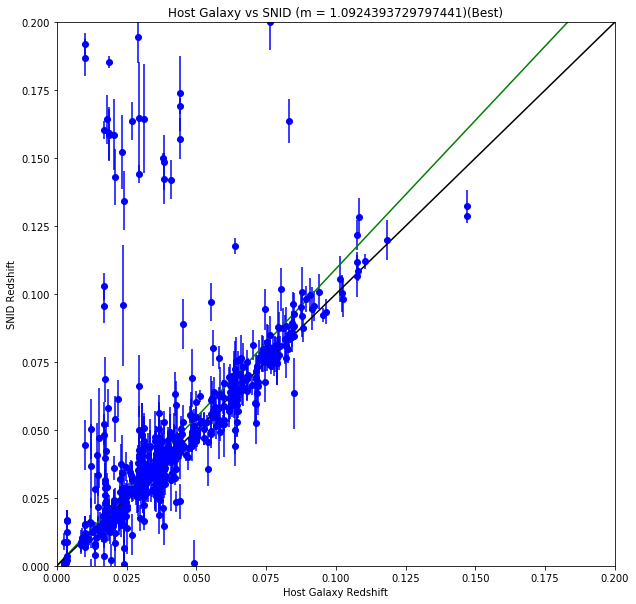

In [141]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_best_JoinedResults_good["z_host"], ZTable_best_JoinedResults_good["z_snid"], ZTable_best_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_best_JoinedResults_good.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_best_good, ypredict_best_good, color = "green")
plt.plot(ranges_best_good, ranges_best_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Best)')

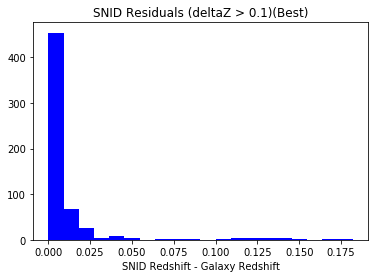

In [37]:
plt.hist(np.abs(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Best)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Best)')

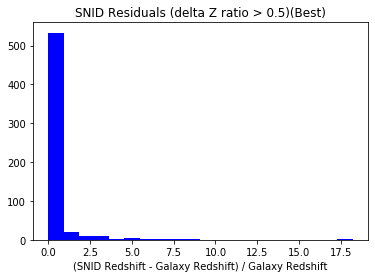

In [38]:
plt.hist(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Best)")

In [160]:
print(np.sum(np.abs((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]) > .5),len(ZTable_best_JoinedResults_good))

84 591


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Best)')

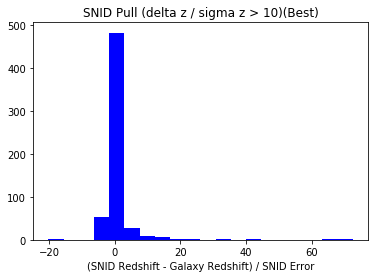

In [39]:
plt.hist(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Best)")

In [144]:
print(stats.median_absolute_deviation(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"])/ZTable_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]))
print(np.std((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_host"]))
print(np.std(((ZTable_best_JoinedResults_good["z_snid"] - ZTable_best_JoinedResults_good["z_host"]) / ZTable_best_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_best_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.00577027920000002
0.1478116969670207
1.2694179915038224
0.028755884105830937
1.5460783015999366
6.049688729976681
715 764


In [49]:
ZTable_average = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        if(np.sum(good[0:15]["zerr"] == 0) == 0):
            row.append(float(sum(good[0:15]["z"] * (1/(good[0:15]["zerr"] ** 2)))/sum(1/(good[0:15]["zerr"] ** 2))))
            row.append(float(1 / (np.sqrt(np.sum(1 / good[0:15]["zerr"] ** 2)))))
            ZTable_average.add_row(row)
ZTable_average_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average, SEDM_ML_sample),final_rcf_table)

6328


In [50]:
print(len(ZTable_average))
print(len(SEDM_ML_sample))

6328
8959


In [51]:
regr_average_JoinedResults_good = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_JoinedResults_good = ZTable_average_JoinedResults[np.where(ZTable_average_JoinedResults["z_host"] > -.1)[0]]
regr_average_JoinedResults_good.fit(ZTable_average_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [52]:
ranges_average_good = np.linspace(0, .2, 100)
ypredict_average_good = regr_average_JoinedResults_good.predict(ranges_average_good.reshape(-1, 1))

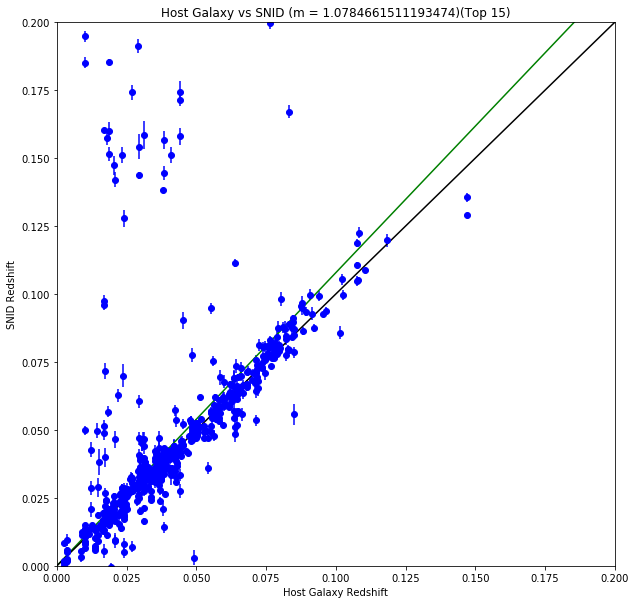

In [53]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_JoinedResults_good["z_host"], ZTable_average_JoinedResults_good["z_snid"], ZTable_average_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_JoinedResults_good.coef_[0][0]) + ")(Top 15)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_good, ypredict_average_good, color = "green")
plt.plot(ranges_average_good, ranges_average_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15)')

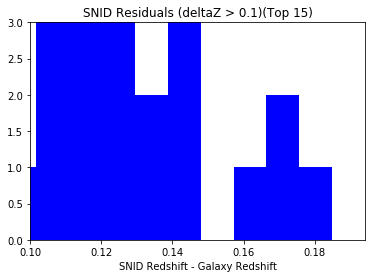

In [54]:
plt.hist(np.abs(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,3)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15)')

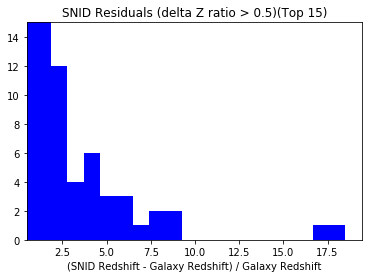

In [55]:
plt.hist(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,15)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15)")

In [156]:
print(np.sum(np.abs((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"])/ZTable_average_JoinedResults_good["z_host"]) > .5),len(ZTable_average_JoinedResults_good))

72 587


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

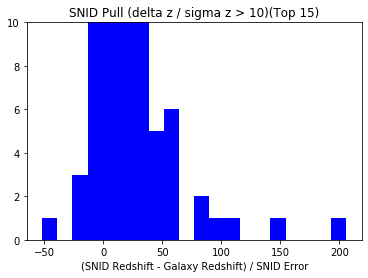

In [57]:
plt.hist(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [145]:
print(stats.median_absolute_deviation(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_JoinedResults_good["z_snid"] - ZTable_average_JoinedResults_good["z_host"]) / ZTable_average_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.004224973704022625
0.10924967243239375
3.1879572897672785
0.028307349830142287
1.5176417019405257
15.916304973695343
714 764


In [136]:
ZTable_average_same = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        if(len(correct) != 0):
            if(np.sum(correct[0:15]["zerr"] == 0) == 0):
                row.append(float(sum(correct[0:15]["z"] * (1/(correct[0:15]["zerr"] ** 2)))/sum(1/(correct[0:15]["zerr"] ** 2))))
                row.append(float(1 / (np.sqrt(np.sum(1 / correct[0:15]["zerr"] ** 2)))))
                ZTable_average_same.add_row(row)
ZTable_average_same_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same, SEDM_ML_sample),final_rcf_table)

In [137]:
print(len(ZTable_average_same))
print(len(SEDM_ML_sample))

6240
8959


In [90]:
regr_average_same_JoinedResults = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_JoinedResults_good = ZTable_average_same_JoinedResults[np.where(ZTable_average_same_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_JoinedResults.fit(ZTable_average_same_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [91]:
ranges_average_same_good = np.linspace(0, .2, 100)
ypredict_average_same_good = regr_average_same_JoinedResults.predict(ranges_average_same_good.reshape(-1, 1))

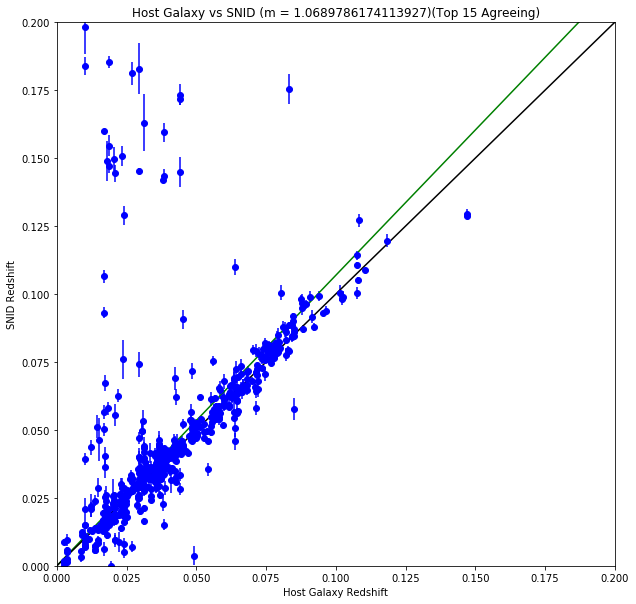

In [92]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_JoinedResults_good["z_host"], ZTable_average_same_JoinedResults_good["z_snid"], ZTable_average_same_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_JoinedResults.coef_[0][0]) + ")(Top 15 Agreeing)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_good, ypredict_average_same_good, color = "green")
plt.plot(ranges_average_same_good, ranges_average_same_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)')

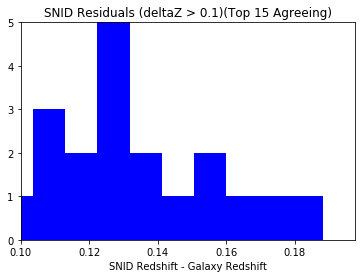

In [93]:
plt.hist(np.abs(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.1)
plt.ylim(0,5)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)')

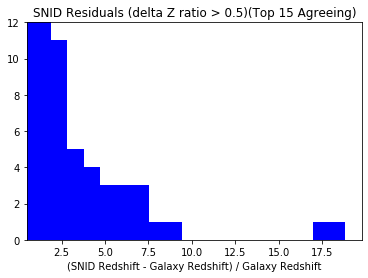

In [94]:
plt.hist(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlim(.5)
plt.ylim(0,12)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Agreeing)")

In [155]:
print(np.sum(np.abs((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"])/ZTable_average_same_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_JoinedResults_good))

73 583


Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top 15)')

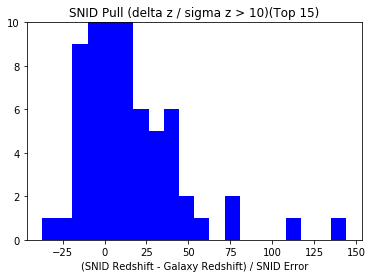

In [96]:
plt.hist(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top 15)")

In [146]:
print(stats.median_absolute_deviation(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_JoinedResults_good["z_snid"] - ZTable_average_same_JoinedResults_good["z_host"]) / ZTable_average_same_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.00435438586409123
0.11512167859442693
3.137751140604262
0.02719247295429374
1.5102490166288687
11.538676687551838
714 764


In [ ]:
unique_counter = 0
ZTable_average_same_unique = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        unique = np.unique(correct["sn"])
        if(len(unique) >= 7):
            indicies = []
            for i in unique[0:15]:
                indicies.append(np.where(correct["sn"] == i)[0][0])
            if(len(correct) != 0):
                if(np.sum(correct[indicies]["zerr"] == 0) == 0):
                    row.append(float(sum(correct[indicies]["z"] * (1/(correct[indicies]["zerr"] ** 2)))/sum(1/(correct[indicies]["zerr"] ** 2))))
                    row.append(float(1 / (np.sqrt(np.sum(1 / correct[indicies]["zerr"] ** 2)))))
                    ZTable_average_same_unique.add_row(row)
ZTable_average_same_unique_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same_unique, SEDM_ML_sample),final_rcf_table)

In [101]:
print(len(ZTable_average_same_unique))
print(len(SEDM_ML_sample))

5452
8959


In [102]:
regr_average_same_unique = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_unique_JoinedResults_good = ZTable_average_same_unique_JoinedResults[np.where(ZTable_average_same_unique_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_unique.fit(ZTable_average_same_unique_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_unique_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [103]:
ranges_average_same_unique_good = np.linspace(0, .2, 100)
ypredict_average_same_unique_good = regr_average_same_unique.predict(ranges_average_same_unique_good.reshape(-1, 1))

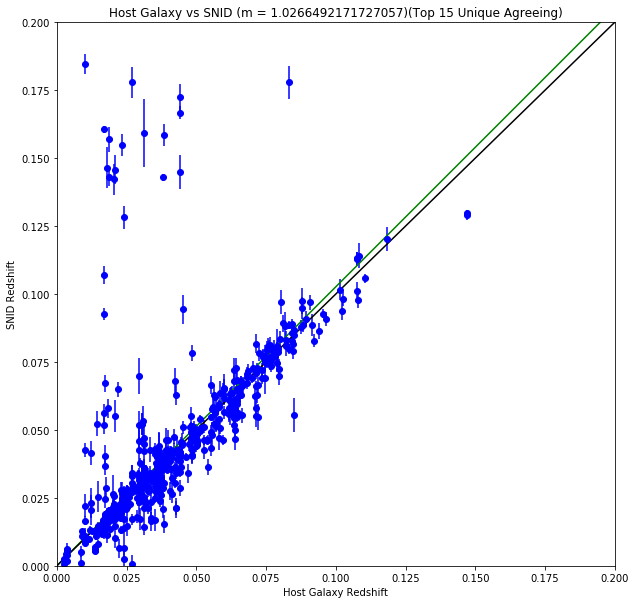

In [104]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_unique_JoinedResults_good["z_host"], ZTable_average_same_unique_JoinedResults_good["z_snid"], ZTable_average_same_unique_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_unique.coef_[0][0]) + ")(Top 15 Unique Agreeing)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_unique_good, ypredict_average_same_unique_good, color = "green")
plt.plot(ranges_average_same_unique_good, ranges_average_same_unique_good, color = "black")

Text(0.5, 1.0, 'SNID Residuals (deltaZ > 0.1)(Top 15 Unique Agreeing)')

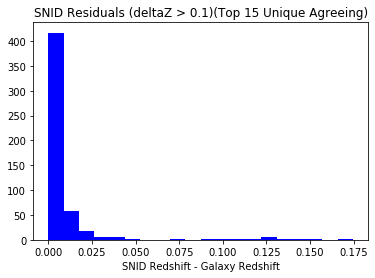

In [105]:
plt.hist(np.abs(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("SNID Redshift - Galaxy Redshift")
plt.title("SNID Residuals (deltaZ > 0.1)(Top 15 Unique Agreeing)")

Text(0.5, 1.0, 'SNID Residuals (delta Z ratio > 0.5)(Top 15 Unique Agreeing Agreeing)')

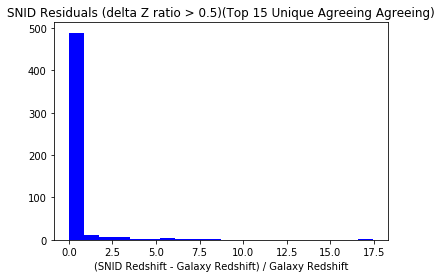

In [106]:
plt.hist(np.abs((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"])/ZTable_average_same_unique_JoinedResults_good["z_host"]), color = "blue", bins = 20)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / Galaxy Redshift")
plt.title("SNID Residuals (delta Z ratio > 0.5)(Top 15 Unique Agreeing Agreeing)")

Text(0.5, 1.0, 'SNID Pull (delta z / sigma z > 10)(Top Unique Agreeing 15)')

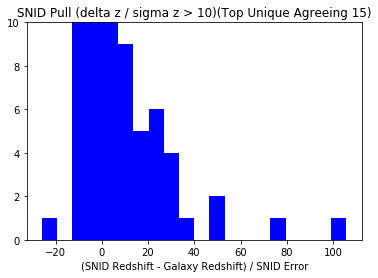

In [107]:
plt.hist(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"]), color = "blue", bins = 20)
plt.ylim(0,10)
plt.xlabel("(SNID Redshift - Galaxy Redshift) / SNID Error")
plt.title("SNID Pull (delta z / sigma z > 10)(Top Unique Agreeing 15)")

In [147]:
print(stats.median_absolute_deviation(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"]) / ZTable_average_same_unique_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_unique_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.004877981673002987
0.12954406091023046
2.2373107534633614
0.024850490334379402
1.267373695320762
8.316455628217527
692 764


In [154]:
print(np.sum(np.abs((ZTable_average_same_unique_JoinedResults_good["z_snid"] - ZTable_average_same_unique_JoinedResults_good["z_host"])/ZTable_average_same_unique_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_unique_JoinedResults_good))

67 526


In [110]:
unique_counter = 0
ZTable_average_same_unique_best = Table(
                    names=("Version", "z_snid", "z_snid_err"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "float64", "float64"
                          )
                    )
for j in snidoutput:
    row = []
    row.append(j[0] + ".ascii")
    good = j[1][np.where(j[1]["grade"] == "good")]
    good = good[np.where(good["z"] <= .2)]
    if(len(good) != 0):
        correct_type = j[1]["type"][0]
        correct = good[np.where(good["type"] == correct_type)[0]]
        unique = np.unique(correct["sn"])
        if(len(unique) >= 7):
            indicies = []
            for i in unique[0:15]:
                indicies.append(np.where(correct["sn"] == i)[0][0])
            if(len(correct) != 0):
                if(np.sum(correct[indicies]["zerr"] == 0) == 0):
                    row.append(float(good[0]["z"]))
                    row.append(float(good[0]["zerr"]))
                    ZTable_average_same_unique_best.add_row(row)
ZTable_average_same_unique_best_JoinedResults = astropy.table.join(astropy.table.join(ZTable_average_same_unique_best, SEDM_ML_sample),final_rcf_table)

In [111]:
regr_average_same_unique_best = linear_model.LinearRegression(fit_intercept = False)
ZTable_average_same_unique_best_JoinedResults_good = ZTable_average_same_unique_best_JoinedResults[np.where(ZTable_average_same_unique_best_JoinedResults["z_host"] > -.1)[0]]
regr_average_same_unique_best.fit(ZTable_average_same_unique_best_JoinedResults_good["z_host"].reshape(-1, 1), ZTable_average_same_unique_best_JoinedResults_good["z_snid"].reshape(-1, 1))

/home/xhall/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [112]:
ranges_average_same_unique_good = np.linspace(0, .2, 100)
ypredict_average_same_unique_best_good = regr_average_same_unique_best.predict(ranges_average_same_unique_good.reshape(-1, 1))

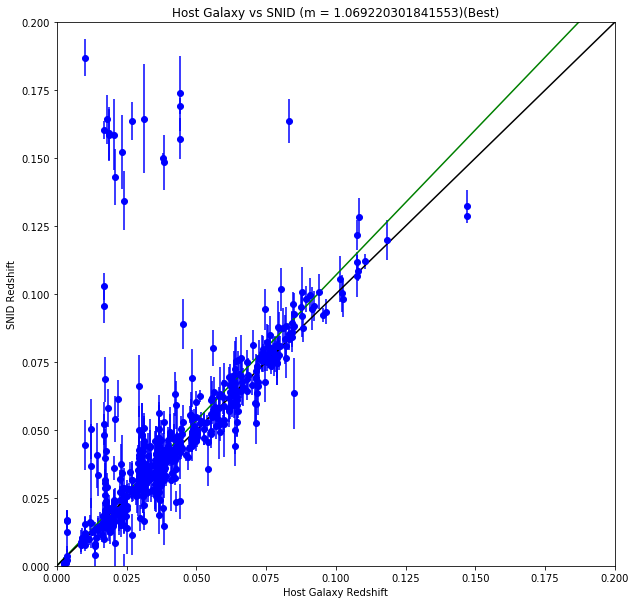

In [151]:
fig = plt.figure(figsize = (10,10))
plt.xlim(0,.2)
plt.ylim(0,.2)
plt.errorbar(ZTable_average_same_unique_best_JoinedResults_good["z_host"], ZTable_average_same_unique_best_JoinedResults_good["z_snid"], ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"], fmt = "o", color = "blue")
plt.title("Host Galaxy vs SNID (m = " + str(regr_average_same_unique_best.coef_[0][0]) + ")(Best)")
plt.xlabel("Host Galaxy Redshift")
plt.ylabel("SNID Redshift")
plt.plot(ranges_average_same_unique_good, ypredict_average_same_unique_best_good, color = "green")
plt.plot(ranges_average_same_unique_good, ranges_average_same_unique_good, color = "black")

In [153]:
print(np.sum(np.abs((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"])/ZTable_average_same_unique_best_JoinedResults_good["z_host"]) > .5),len(ZTable_average_same_unique_best_JoinedResults_good))

59 526


In [150]:
print(stats.median_absolute_deviation(ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(stats.median_absolute_deviation(((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"])))
print(np.std(ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(np.std((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_host"]))
print(np.std(((ZTable_average_same_unique_best_JoinedResults_good["z_snid"] - ZTable_average_same_unique_best_JoinedResults_good["z_host"]) / ZTable_average_same_unique_best_JoinedResults_good["z_snid_err"])))
print(len(np.unique(ZTable_average_same_unique_best_JoinedResults["ZTF_Name"])),len(final_rcf_table))

0.005569386900000007
0.1432712575029212
1.2487682304207122
0.024839792985636423
1.3104250538257058
4.860830617132809
692 764
